# Training & Evaluation

This notebook covers the training and evaluation of the churn prediction model using both traditional demographic features and graph-based features derived from Neo4j's Graph Data Science library. The goal is to identify users at risk of churning based on their transaction behavior and network relationships.

In [1]:
# Load .env variables
from dotenv import load_dotenv
import os

load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE", "neo4j")

In [2]:
# Open session with Neo4j
from neo4j import GraphDatabase

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
session = driver.session(database=NEO4J_DATABASE)

## Graph Schema Visualization
Define a function to visualize the Neo4j database schema using NetworkX.

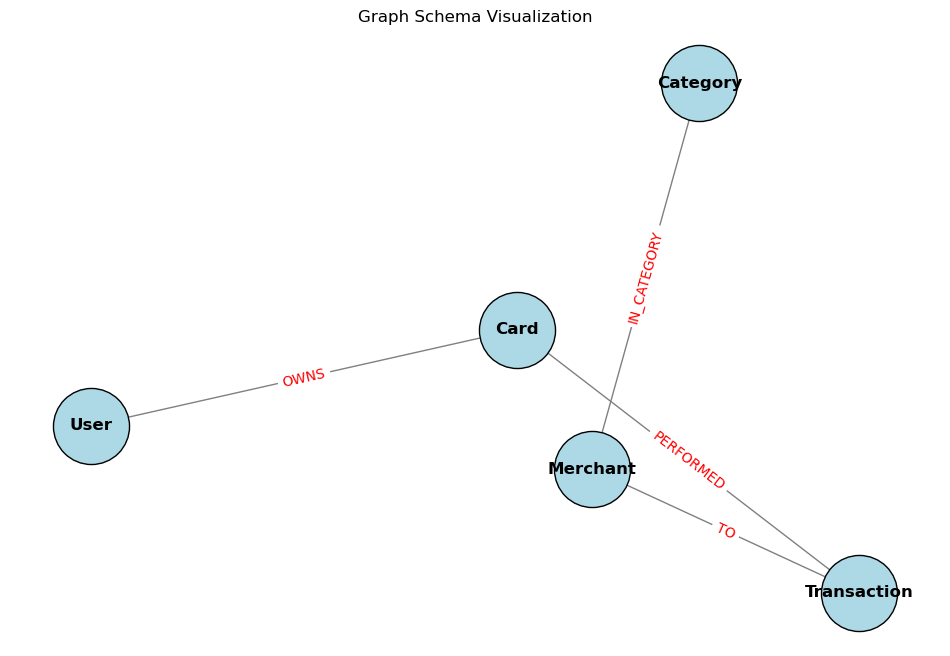

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_schema(session, uri, auth):
    driver = GraphDatabase.driver(uri, auth=auth)
    
    query = "CALL db.schema.visualization()"
    
    G = nx.DiGraph()
    
    with session.begin_transaction() as tx:
        result = tx.run(query)
        record = result.single()
        
        # Parse Nodes (Labels)
        # The schema query returns nodes that represent the Labels themselves.
        # We use the 'name' property (or the first label) as the node ID.
        for node in record["nodes"]:
            # Schema nodes usually have the label name as a property or as the label itself
            # In modern Neo4j, the node usually has labels like ["User"] and properties like {name: "User"}
            label = list(node.labels)[0] if node.labels else "Unknown"
            # Sometimes the schema node has a property 'name' containing the label
            if "name" in node.keys():
                label = node["name"]
            
            G.add_node(label, type="Node")

        # Parse Relationships
        for rel in record["relationships"]:
            start_node = rel.start_node
            end_node = rel.end_node
            
            # Extract label names for start/end
            src = start_node["name"] if "name" in start_node.keys() else list(start_node.labels)[0]
            dst = end_node["name"] if "name" in end_node.keys() else list(end_node.labels)[0]
            
            rel_type = rel.type
            
            G.add_edge(src, dst, label=rel_type)
            
    driver.close()

    # 5. Draw with NetworkX
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=1.5, iterations=50) # 'k' controls the spacing
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', edgecolors='black')
    
    # Draw Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Draw Edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
    
    # Draw Edge Labels (The Relationship Types)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Graph Schema Visualization")
    plt.axis('off')
    plt.show()

# Run it
draw_schema(session, NEO4J_URI, (NEO4J_USER, NEO4J_PASSWORD))

## Helper Functions
Define a helper function to execute Cypher queries.

In [4]:
def run_cypher(session, query, parameters=None):
    """Helper function to run Cypher queries."""
    results = []
    with session.begin_transaction() as tx:
        # Split by semicolon to handle multiple statements
        for statement in query.split(';'):
            if statement.strip():  # Skip empty strings
                result = tx.run(statement, parameters)
                # Only fetch data if there are records to consume
                if result.peek():
                    results.append(result.data())
    
    # Return the last result or all results depending on preference, 
    # here we return the last non-empty one or empty list
    return results[-1] if results else []

## Define Cypher Queries
Here we define all the Cypher queries required for the GDS pipeline. This includes cleanup, data preparation, graph projection, feature engineering, model training, and inference.

In [5]:
# Define all necessary queries which we will be using later
queries = {
    # -------------------------------------------------------------------------
    # SETUP & CLEANUP
    # -------------------------------------------------------------------------
    "01_cleanup": """
        CALL gds.graph.drop('churnGraph', false);
        CALL gds.graph.drop('fullGraph', false);
        CALL gds.beta.pipeline.drop('churnPipeline', false);
        CALL gds.model.drop('churnModel', false);
    """,

    "02_remove_temp_labels": """
        MATCH (u:TrainingCohort) REMOVE u:TrainingCohort;
    """,

    # -------------------------------------------------------------------------
    # DATA PREPARATION (Undersampling & Materialization)
    # -------------------------------------------------------------------------
    "03_prepare_data": """
        // 1. Label the Training Cohort (Undersampling)
        MATCH (u:User)
        WHERE u.churned = 1 OR rand() < 0.05
        SET u:TrainingCohort;

        // 2. Materialize the Relationship for EVERYONE (needed for both graphs)
        // Note: Doing this for all users now saves time later
        MATCH (u:User)-[:OWNS]->(:Card)-[:PERFORMED]->(t:Transaction)-[:TO]->(m:Merchant)
        WITH u, m, count(t) AS weight
        MERGE (u)-[r:SHOPPED_AT]->(m)
        SET r.weight = weight;
    """,

    # -------------------------------------------------------------------------
    # TRAINING PHASE
    # -------------------------------------------------------------------------
    "04_project_training_graph": """
        CALL gds.graph.project(
            'churnGraph',
            {
                TrainingCohort: {
                    properties: ['churned', 'yearly_income', 'total_debt', 'credit_score']
                },
                Merchant: { properties: [] }
            },
            {
                SHOPPED_AT: {
                    orientation: 'UNDIRECTED',
                    properties: 'weight'
                }
            }
        );
    """,

    "05_features_training": """
        // Feature Engineering on TRAINING Graph
        CALL gds.fastRP.mutate('churnGraph', {
            embeddingDimension: 32, 
            relationshipWeightProperty: 'weight',
            mutateProperty: 'embedding_fastrp'
        });

        CALL gds.pageRank.mutate('churnGraph', {
            relationshipWeightProperty: 'weight',
            mutateProperty: 'score_pagerank'
        });
    """,

    "06_configure_pipeline": """
        // 1. Create Pipeline
        CALL gds.beta.pipeline.nodeClassification.create('churnPipeline');

        // 2. Select Features
        CALL gds.beta.pipeline.nodeClassification.selectFeatures('churnPipeline', [
            'embedding_fastrp', 
            'score_pagerank', 
            'yearly_income', 
            'total_debt', 
            'credit_score'
        ]);

        // 3. Configure Split (Low folds for small data)
        CALL gds.beta.pipeline.nodeClassification.configureSplit('churnPipeline', {
            testFraction: 0.2,
            validationFolds: 2
        });

        // 4. Add Model
        CALL gds.beta.pipeline.nodeClassification.addRandomForest('churnPipeline', {
            numberOfDecisionTrees: 50,
            maxDepth: 5,
            minLeafSize: 1,
            minSplitSize: 2
        });
    """,

    "07_train_model": """
        CALL gds.beta.pipeline.nodeClassification.train(
            'churnGraph',
            {
                pipeline: 'churnPipeline',
                targetNodeLabels: ['TrainingCohort'], 
                modelName: 'churnModel',
                targetProperty: 'churned',
                metrics: ['ACCURACY', 'OUT_OF_BAG_ERROR', 'PRECISION(class=1)', 'RECALL(class=1)']
            }
        )
        YIELD modelInfo, modelSelectionStats
        RETURN 
            modelInfo.metrics.ACCURACY AS Accuracy,
            modelInfo.metrics['PRECISION(class=1)'] AS Precision,
            modelInfo.metrics['RECALL(class=1)'] AS Recall;
    """,

    # -------------------------------------------------------------------------
    # INFERENCE PHASE (Predicting on Everyone)
    # -------------------------------------------------------------------------
    "08_project_inference_graph": """
        // Project the FULL graph (All Users)
        CALL gds.graph.project(
            'fullGraph',
            {
                User: {
                    properties: ['churned', 'yearly_income', 'total_debt', 'credit_score']
                },
                Merchant: { properties: [] }
            },
            {
                SHOPPED_AT: {
                    orientation: 'UNDIRECTED',
                    properties: 'weight'
                }
            }
        );
    """,

    "09_features_inference": """
        // Feature Engineering on FULL Graph
        // MUST match the exact settings from '05_features_training'
        CALL gds.fastRP.mutate('fullGraph', {
            embeddingDimension: 32, 
            relationshipWeightProperty: 'weight',
            mutateProperty: 'embedding_fastrp'
        });

        CALL gds.pageRank.mutate('fullGraph', {
            relationshipWeightProperty: 'weight',
            mutateProperty: 'score_pagerank'
        });
    """,

    "10_predict_churn": """
        CALL gds.beta.pipeline.nodeClassification.predict.stream(
            'fullGraph',
            {
                modelName: 'churnModel',
                includePredictedProbabilities: true,
                targetNodeLabels: ['User'] // Apply the logic learned on 'TrainingCohort' to 'User'
            }
        )
        YIELD nodeId, predictedClass, predictedProbabilities
        WITH 
            gds.util.asNode(nodeId) AS user, 
            predictedClass,
            predictedProbabilities[1] AS Risk_Score

        // Filter: Show 'Active' users that the model thinks are risky
        WHERE user.churned = 0

        RETURN 
            user.id AS UserID, 
            user.yearly_income AS Income,
            user.credit_score AS Credit_Score,
            Risk_Score, 
            predictedClass
        ORDER BY Risk_Score DESC
        LIMIT 25;
    """
}

## 1. Setup & Data Preparation
Execute the initial steps:
1.  **Cleanup**: Remove old graphs and pipelines.
2.  **Data Prep**: Undersample the majority class (active users) to create a balanced `TrainingCohort` and materialize the `SHOPPED_AT` relationship.
3.  **Graph Projection**: Project the training graph into memory.

In [6]:
# 01
run_cypher(session, queries["01_cleanup"])

# 02
run_cypher(session, queries["02_remove_temp_labels"])

# 03
run_cypher(session, queries["03_prepare_data"])

# 04
run_cypher(session, queries["04_project_training_graph"])

Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. `schema` returned by the procedure `gds.graph.drop` is deprecated.', position=<SummaryInputPosition line=2, column=9, offset=9>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 9, 'line': 2, 'column': 9}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\n        CALL gds.graph.drop('churnGraph', false)"
Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. `schema` returned by the procedure `gds.graph.drop` is deprecated.', position=<SummaryInputPosition line=2, column=9, offset=9>, raw_classification='DEPRECATION', classification=<Notific

[{'nodeProjection': {'Merchant': {'properties': {}, 'label': 'Merchant'},
   'TrainingCohort': {'properties': {'yearly_income': {'property': 'yearly_income',
      'defaultValue': None},
     'credit_score': {'property': 'credit_score', 'defaultValue': None},
     'total_debt': {'property': 'total_debt', 'defaultValue': None},
     'churned': {'property': 'churned', 'defaultValue': None}},
    'label': 'TrainingCohort'}},
  'relationshipProjection': {'SHOPPED_AT': {'orientation': 'UNDIRECTED',
    'aggregation': 'DEFAULT',
    'type': 'SHOPPED_AT',
    'properties': {'weight': {'property': 'weight',
      'aggregation': 'DEFAULT',
      'defaultValue': None}},
    'indexInverse': False}},
  'graphName': 'churnGraph',
  'nodeCount': 68506,
  'relationshipCount': 37042,
  'projectMillis': 783}]

## Verify Schema Changes
Visualize the schema again to confirm that the `SHOPPED_AT` relationships have been created.

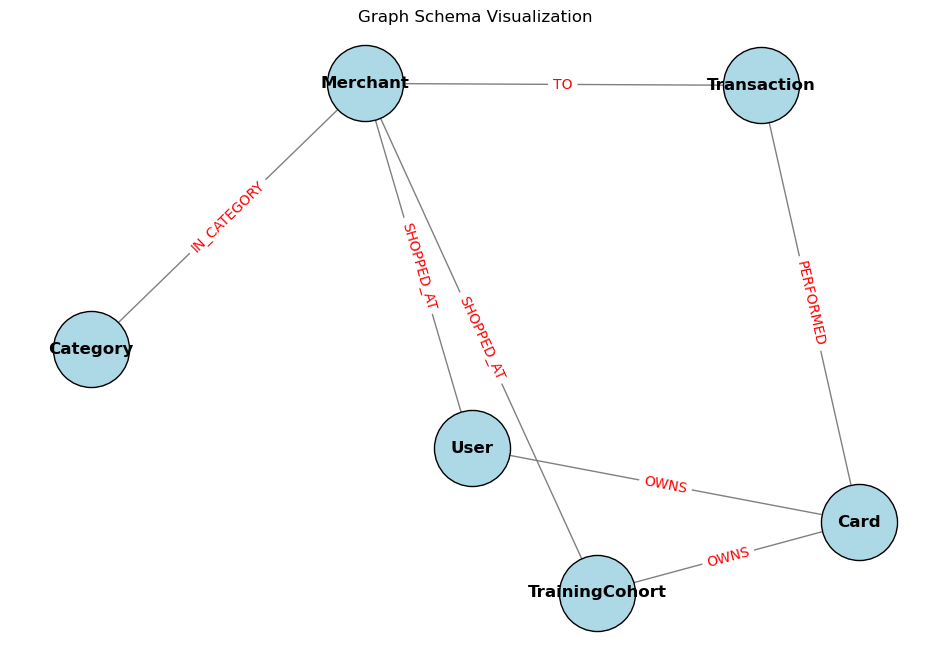

In [7]:
draw_schema(session, NEO4J_URI, (NEO4J_USER, NEO4J_PASSWORD))

## 2. Feature Engineering (Training)
Generate graph features for the training cohort:
*   **FastRP**: Node embeddings.
*   **PageRank**: Centrality scores.

In [8]:
import pandas as pd

# 05
res = run_cypher(session, queries["05_features_training"])
df = pd.DataFrame(res)
display(df)

,ranIterations,didConverge,centralityDistribution,preProcessingMillis,computeMillis,postProcessingMillis,mutateMillis,nodePropertiesWritten,configuration
0,20,False,"{'p99': 0.559565544128418, 'min': 0.1499996185...",0,143,16,0,68506,"{'maxIterations': 20, 'relationshipWeightPrope..."


## 3. Pipeline Configuration
Create and configure the classification pipeline:
*   Select features (embeddings, PageRank, demographic properties).
*   Configure cross-validation split.
*   Add a Random Forest model.

In [9]:
# 06
res = run_cypher(session, queries["06_configure_pipeline"])
df = pd.DataFrame(res)
display(df)

,name,nodePropertySteps,featureProperties,splitConfig,autoTuningConfig,parameterSpace
0,churnPipeline,[],"[embedding_fastrp, score_pagerank, yearly_inco...","{'testFraction': 0.2, 'validationFolds': 2}",{'maxTrials': 10},"{'MultilayerPerceptron': [], 'LogisticRegressi..."


## 4. Model Training
Train the model on the `churnGraph` using the `TrainingCohort` nodes. We evaluate using Accuracy, Precision, and Recall.

In [10]:
# 07
res = run_cypher(session, queries["07_train_model"])
df = pd.DataFrame(res)
display(df)

,Accuracy,Precision,Recall
0,"{'test': 0.75, 'outerTrain': 0.88333334, 'vali...",None,None


## 5. Inference Graph Projection
Now that the model is trained, we project the **full graph** (all users) to run predictions on everyone.

In [11]:
# 08
res = run_cypher(session, queries["08_project_inference_graph"])
df = pd.DataFrame(res)
display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Merchant': {'properties': {}, 'label': 'Merc...","{'SHOPPED_AT': {'orientation': 'UNDIRECTED', '...",fullGraph,69649,634312,1124


## 6. Feature Engineering (Inference)
Generate the same graph features (FastRP, PageRank) for the full graph. **Crucial:** The parameters must match the training phase exactly.

In [12]:
# 09
res = run_cypher(session, queries["09_features_inference"])
df = pd.DataFrame(res)
display(df)

,ranIterations,didConverge,centralityDistribution,preProcessingMillis,computeMillis,postProcessingMillis,mutateMillis,nodePropertiesWritten,configuration
0,20,False,"{'p99': 24.258788108825684, 'min': 0.151714324...",0,130,11,0,69649,"{'maxIterations': 20, 'relationshipWeightPrope..."


## 7. Predict Churn
Apply the trained model to the full graph to predict the churn probability for **active** users. We list the top 25 users with the highest risk scores.

In [13]:
# 10
res = run_cypher(session, queries["10_predict_churn"])
df = pd.DataFrame(res)
display(df)

,UserID,Income,Credit_Score,Risk_Score,predictedClass
0,1428,28472.0,508,0.52,1
1,1648,185909.0,621,0.50,0
2,1910,35868.0,562,0.48,0
3,1376,62019.0,543,0.48,0
4,1629,29422.0,598,0.46,0
5,1753,45476.0,506,0.46,0
6,1535,33311.0,590,0.46,0
7,1263,36652.0,600,0.44,0
8,94,36760.0,593,0.44,0
9,39,61740.0,583,0.44,0
